In [66]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import math
import copy
from collections import deque

maze_size = 8
n_obstacles = 10

# 考虑一个8*8的gridworld，起点在左上角，终点在右下角，使用Q-Learning找到终点。
# Define the gridworld
grid = np.zeros((maze_size, maze_size))
start = (0, 0)
goal = (maze_size-1, maze_size-1)

# Check if there is a valid path from start to goal
def is_maze_solvable(grid, start, goal, obstacles):
    visited = np.zeros((maze_size, maze_size), dtype=bool)
    queue = deque([start])

    while queue:
        current = queue.popleft()
        visited[current] = True

        if current == goal:
            return True

        for d in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
            next_state = (current[0] + d[0], current[1] + d[1])

            if (0 <= next_state[0] < maze_size) and (0 <= next_state[1] < maze_size) and not visited[next_state] and next_state not in obstacles:
                queue.append(next_state)
                visited[next_state] = True

    return False

# Generate random obstacles and ensure the maze is solvable
def generate_obstacles(start, goal, num_obstacles):
    obstacles = set()
    while True:
        while len(obstacles) < num_obstacles:
            obstacle = (np.random.randint(0, maze_size), np.random.randint(0, maze_size))
            if obstacle not in {start, goal}:
                obstacles.add(obstacle)
        
        if is_maze_solvable(grid, start, goal, obstacles):
            break
        else:
            obstacles.clear()

    return obstacles

# Generate solvable obstacles
obstacles = generate_obstacles(start, goal, num_obstacles=n_obstacles)

# Define the Q-learning parameters
alpha = 0.1
gamma = 0.9
epsilon = 0.1


# Define the Q-learning function
def q_learning(grid, start, goal, alpha, gamma, epsilon):
    # Initialize the Q-values
    q_values = np.zeros((maze_size, maze_size, 4))

    steps_done = 0
    EPS_START = 0.95
    EPS_END = 0.05
    EPS_DECAY = 10000000

    # Define the actions
    actions = ['up', 'down', 'left', 'right']

    # Define the rewards
    rewards = np.zeros((maze_size, maze_size))
    rewards[goal] = 1

    for obstacle in obstacles:
        rewards[obstacle] = -1

    # Define the policy
    def policy(state, steps_done):
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
#         eps_threshold = 0.1
        if np.random.uniform() < eps_threshold:
            return np.random.choice(actions)
        else:
            return actions[np.argmax(q_values[state])]

    # Define the update rule
    def update(state, action, next_state, reward):
        q_values[state][actions.index(action)] += alpha * (
            reward + gamma * np.max(q_values[next_state]) - q_values[state][actions.index(action)])

    # Run the Q-learning algorithm
    for i in trange(1000):
        state = start
        while state != goal:
            action = policy(state, steps_done)
            steps_done += 1
            if action == 'up':
                next_state = (max(state[0] - 1, 0), state[1])
            elif action == 'down':
                next_state = (min(state[0] + 1, maze_size-1), state[1])
            elif action == 'left':
                next_state = (state[0], max(state[1] - 1, 0))
            elif action == 'right':
                next_state = (state[0], min(state[1] + 1, maze_size-1))
            reward = rewards[next_state]
            if next_state in obstacles:
                next_state = state
            update(state, action, next_state, reward)
            state = next_state

    # Return the Q-values
    return q_values


# Run the Q-learning function
q_values = q_learning(grid, start, goal, alpha, gamma, epsilon)

# Print the Q-values
# print(q_values)

100%|██████████| 1000/1000 [00:04<00:00, 242.80it/s]


In [67]:
def display_grid_with_obstacles(grid, start, goal, obstacles):
    grid_representation = grid.copy()

    # Set the start, goal, and obstacles on the grid
    grid_representation[start] = 2
    grid_representation[goal] = 3
    for obstacle in obstacles:
        grid_representation[obstacle] = -1

    # Define a custom print function for grid cells
    def print_cell(value):
        if value == 2:
            return "S"
        elif value == 3:
            return "G"
        elif value == -1:
            return "X"
        else:
            return "."

    # Print the grid with obstacles
    for row in grid_representation:
        print(" ".join([print_cell(value) for value in row]))

# Call the function to display the grid with obstacles
display_grid_with_obstacles(grid, start, goal, obstacles)


S . . . . X . .
. . . X . . . .
. . . . . . . X
X . . . . X . .
X . . . . . . .
. . . X . . . .
X . . . . . X .
. . . X . . . G


In [68]:
policy = np.zeros((maze_size, maze_size))

for i in range(maze_size):
    for j in range(maze_size):
        policy[i][j] = np.max(q_values[(i, j)])

print(policy)

[[0.25418658 0.28242954 0.3138106  0.34867844 0.38742049 0.
  0.4782969  0.43046721]
 [0.28242954 0.3138106  0.34867844 0.         0.43046721 0.4782969
  0.531441   0.4782969 ]
 [0.3138106  0.34867844 0.38742049 0.43046721 0.4782969  0.531441
  0.59049    0.        ]
 [0.         0.38742049 0.43046721 0.4782969  0.531441   0.
  0.6561     0.729     ]
 [0.         0.43046721 0.4782969  0.531441   0.59049    0.6561
  0.729      0.81      ]
 [0.43046721 0.4782969  0.531441   0.         0.6561     0.729
  0.81       0.9       ]
 [0.         0.531441   0.59049    0.6561     0.729      0.81
  0.         1.        ]
 [0.43046721 0.4782969  0.531441   0.         0.81       0.9
  1.         0.        ]]


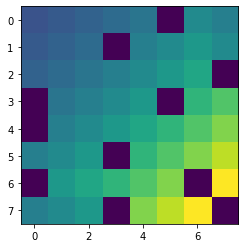

In [69]:
plt.imshow(policy)
plt.show()

In [77]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# Define the DQN architecture
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the DQN function
def dqn_learning(grid, start, goal, obstacles):
    # Initialize the DQN and the target network
    dqn = DQN(2, 4)
    target_net = DQN(2, 4)
    target_net.load_state_dict(dqn.state_dict())

    # Set the optimizer and the loss function
    optimizer = optim.Adam(dqn.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Hyperparameters
    gamma = 0.9
    epsilon_start = 0.95
    epsilon_end = 0.05
    epsilon_decay = 1000000
    target_update = 1000
    num_episodes = 1000

    steps_done = 0

    # Run the DQN learning algorithm
    for episode in trange(num_episodes):
        state = torch.tensor(start, dtype=torch.float32).unsqueeze(0)
        while True:
            # Choose an action based on epsilon-greedy policy
            epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1.0 * steps_done / epsilon_decay)
            if np.random.rand() < epsilon:
                action = np.random.randint(4)
            else:
                action = torch.argmax(dqn(state)).item()

            # Perform the action and get the next state
            if action == 0:  # up
                next_state = (max(state[0, 0] - 1, 0), state[0, 1])
            elif action == 1:  # down
                next_state = (min(state[0, 0] + 1, 7), state[0, 1])
            elif action == 2:  # left
                next_state = (state[0, 0], max(state[0, 1] - 1, 0))
            elif action == 3:  # right
                next_state = (state[0, 0], min(state[0, 1] + 1, 7))

            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

            # Get the reward
            reward = 1.0 if tuple(next_state[0].numpy().astype(int)) == goal else -1.0 if tuple(next_state[0].numpy().astype(int)) in obstacles else 0.0

            # If collided with an obstacle, don't change the state
            if tuple(next_state[0].numpy().astype(int)) in obstacles:
                next_state = state

            # Update the DQN
            current_q_value = dqn(state)[0, action]
            next_q_value = reward + gamma * torch.max(target_net(next_state)).detach()
            if tuple(next_state[0].numpy().astype(int)) == goal:
                target_q_value = torch.tensor(reward)
            else:
                target_q_value = reward + gamma * torch.max(target_net(next_state))

            # Calculate the loss
            loss = criterion(current_q_value, target_q_value)

            # Optimize the model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the target network
            steps_done += 1
            if steps_done % target_update == 0:
                target_net.load_state_dict(dqn.state_dict())

            # Update the state
            state = next_state

            # Check if the goal is reached
            if tuple(state[0].numpy().astype(int)) == goal:
                break

    return dqn

# Run the DQN learning function
dqn = dqn_learning(grid, start, goal, obstacles)

# Test the trained DQN model
state = torch.tensor(start, dtype=torch.float32).unsqueeze(0)
while tuple(state[0].numpy().astype(int)) != goal:
    action = torch.argmax(dqn(state)).item()
    if action == 0:  # up
        next_state = (max(state[0, 0] - 1, 0), state[0, 1])
    elif action == 1:  # down
        next_state = (min(state[0, 0] + 1, 7), state[0, 1])
    elif action == 2:  # left
        next_state = (state[0, 0], max(state[0, 1] - 1, 0))
    elif action == 3:  # right
        next_state = (state[0, 0], min(state[0, 1] + 1, 7))

    print(state[0].numpy().astype(int), "->", next_state)
    state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

            


 32%|███▏      | 323/1000 [09:49<20:34,  1.82s/it]  


KeyboardInterrupt: 

In [79]:
# Test the trained DQN model
state = torch.tensor(start, dtype=torch.float32).unsqueeze(0)
while tuple(state[0].numpy().astype(int)) != goal:
    action = torch.argmax(dqn(state)).item()
    if action == 0:  # up
        next_state = (max(state[0, 0] - 1, 0), state[0, 1])
    elif action == 1:  # down
        next_state = (min(state[0, 0] + 1, 7), state[0, 1])
    elif action == 2:  # left
        next_state = (state[0, 0], max(state[0, 1] - 1, 0))
    elif action == 3:  # right
        next_state = (state[0, 0], min(state[0, 1] + 1, 7))

    print(state[0].numpy().astype(int), "->", next_state)
    state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)
[0 0] -> (tensor(0.), 0)


KeyboardInterrupt: 

In [156]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def create_state(grid, position):
    grid_with_position = grid.copy()
    grid_with_position[position] = 2  # Agent position
    grid_with_position[goal] = 3  # Goal position
    for obstacle in obstacles:
        grid_with_position[obstacle] = -1  # Obstacle position
    return torch.tensor(grid_with_position, dtype=torch.float32).flatten().to(device)


def dqn_learning(grid, start, goal, obstacles, batch_size=64, memory_capacity=10000):
    # Initialize the DQN and the target network
    dqn = DQN(64, 4).to(device)
    target_net = DQN(64, 4).to(device)
    target_net.load_state_dict(dqn.state_dict())

    # Set the optimizer and the loss function
    optimizer = optim.Adam(dqn.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Hyperparameters
    gamma = 0.9
    epsilon_start = 0.95
    epsilon_end = 0.05
    epsilon_decay = 50000
    target_update = 1000
    num_episodes = 500

    steps_done = 0

    # Initialize the replay memory
    memory = ReplayMemory(memory_capacity)

    # Initialize the grid with obstacles
    grid = np.zeros((8, 8))
    for obstacle in obstacles:
        grid[obstacle] = -1

    # Run the DQN learning algorithm
    for episode in trange(num_episodes):
        state = create_state(grid, start)
        while True:
            # Choose an action based on epsilon-greedy policy
            epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1.0 * steps_done / epsilon_decay)
            if np.random.rand() < epsilon:
                action = np.random.randint(4)
            else:
                action = torch.argmax(dqn(state.unsqueeze(0))).item()

            # Perform the action and get the next state
            current_position = np.unravel_index(np.argmax(state.cpu().numpy() == 2), grid.shape)
            if action == 0:  # up
                next_position = (max(current_position[0] - 1, 0), current_position[1])
            elif action == 1:  # down
                next_position = (min(current_position[0] + 1, 7), current_position[1])
            elif action == 2:  # left
                next_position = (current_position[0], max(current_position[1] - 1, 0))
            elif action == 3:  # right
                next_position = (current_position[0], min(current_position[1] + 1, 7))

            next_state = create_state(grid, next_position)

            # Get the reward
            reward = 1.0 if next_position == goal else -1.0 if next_position in obstacles else -0.1

            # If collided with an obstacle, don't change the state
            if next_position in obstacles:
                next_state = state

            # Store the transition in the replay memory
            memory.push((state, action, reward, next_state))

            # Update the state
            state = next_state

            # Check if the goal is reached
            if next_position == goal:
                break

            # Check if enough samples are available in the memory
            if len(memory) >= batch_size:
                # Sample a batch of transitions from the memory
                transitions = memory.sample(batch_size)
                states, actions, rewards, next_states = zip(*transitions)

                # Convert the data to tensors
                states = torch.stack(states).to(device)
                actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device)
                rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
                next_states = torch.stack(next_states).to(device)

                # Compute the predicted Q-values
                predicted_q_values = dqn(states).gather(1, actions)

                # Compute the target Q-values
                with torch.no_grad():
                    target_q_values = rewards + gamma * target_net(next_states).max(1)[0].unsqueeze(1)

                # Compute the loss
                loss = criterion(predicted_q_values, target_q_values)

                # Optimize the DQN
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Increment the number of steps done
                steps_done += 1

                # Update the target network if necessary
                if steps_done % target_update == 0:
                    target_net.load_state_dict(dqn.state_dict())

    return dqn



Define the gridworld


In [157]:
def display_grid_with_obstacles(grid, start, goal, obstacles):
    grid_representation = grid.copy()

    # Set the start, goal, and obstacles on the grid
    grid_representation[start] = 2
    grid_representation[goal] = 3
    for obstacle in obstacles:
        grid_representation[obstacle] = -1

    # Define a custom print function for grid cells
    def print_cell(value):
        if value == 2:
            return "S"
        elif value == 3:
            return "G"
        elif value == -1:
            return "X"
        else:
            return "."

    # Print the grid with obstacles
    for row in grid_representation:
        print(" ".join([print_cell(value) for value in row]))


In [158]:
start = (0, 0)
goal = (7, 7)
obstacles = [(0, 3), (1, 1), (1, 2), (2, 5), (2, 7), (3, 4), (3, 5), (4, 0), (4, 4), (5, 3), (6, 2), (7, 5)]
# Call the function to display the grid with obstacles
display_grid_with_obstacles(grid, start, goal, obstacles)

S . . X . . . .
. X X . . . . .
. . . . . X . X
. . . . X X . .
X . . . X . . .
. . . X . . . .
. . X . . . . .
. . . . . X . G


Run the DQN learning function

In [159]:
dqn = dqn_learning(grid, start, goal, obstacles)

 10%|█         | 50/500 [00:14<02:11,  3.43it/s]


KeyboardInterrupt: 

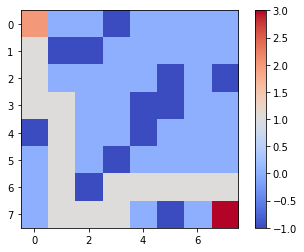

In [119]:
import matplotlib.pyplot as plt

def display_grid_test(grid, start, goal, obstacles, path):
    # Create a grid with obstacles
    grid_with_obstacles = grid.copy()
    for obstacle in obstacles:
        grid_with_obstacles[obstacle] = -1

    # Add start, goal, and path positions
    grid_with_obstacles[start] = 2
    grid_with_obstacles[goal] = 3
    for position in path:
        if position not in (start, goal):
            grid_with_obstacles[position] = 1

    # Display the grid
    plt.imshow(grid_with_obstacles, cmap="coolwarm")
    plt.colorbar()
    plt.show()

def test_dqn(dqn, grid, start, goal, obstacles, max_steps=50):
    state = create_state(grid, start)
    current_position = start
    steps = 0
    path = [start]

    while current_position != goal and steps < max_steps:
        # Choose the best action
        action = torch.argmax(dqn(state.unsqueeze(0))).item()

        # Perform the action and get the next state
        if action == 0:  # up
            next_position = (max(current_position[0] - 1, 0), current_position[1])
        elif action == 1:  # down
            next_position = (min(current_position[0] + 1, 7), current_position[1])
        elif action == 2:  # left
            next_position = (current_position[0], max(current_position[1] - 1, 0))
        elif action == 3:  # right
            next_position = (current_position[0], min(current_position[1] + 1, 7))

        # If collided with an obstacle, don't change the position
        if next_position in obstacles:
            next_position = current_position

        # Update the state and position
        state = create_state(grid, next_position)
        current_position = next_position
        path.append(current_position)

        steps += 1

    return path

# Test the trained DQN and get the path
path = test_dqn(dqn, grid, start, goal, obstacles)

# Display the grid with obstacles and the path
display_grid_test(grid, start, goal, obstacles, path)



这段代码将DQN和全局观测结合起来，并在CUDA上运行。全局观测通过在`create_state`函数中将智能体的位置添加到网格上实现。


In [221]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def create_state(grid, position):
    grid_with_position = grid.copy()
    grid_with_position[position] = 2  # Agent position
    grid_with_position[goal] = 3  # Goal position
    for obstacle in obstacles:
        grid_with_position[obstacle] = -1  # Obstacle position
    return torch.tensor(grid_with_position, dtype=torch.float32).flatten().to(device)

def create_local_state(grid, position, view_size=3):
    local_grid = np.zeros((view_size, view_size))

    for i in range(-view_size // 2, view_size // 2 + 1):
        for j in range(-view_size // 2, view_size // 2 + 1):
            row = position[0] + i
            col = position[1] + j
            if row < 0 or row >= grid.shape[0] or col < 0 or col >= grid.shape[1]:
                local_grid[i + view_size // 2, j + view_size // 2] = -1
            elif (row, col) == goal:
                local_grid[i + view_size // 2, j + view_size // 2] = 3
            elif (row, col) in obstacles:
                local_grid[i + view_size // 2, j + view_size // 2] = -1
            elif (row, col) == position:
                local_grid[i + view_size // 2, j + view_size // 2] = 2
            else:
                local_grid[i + view_size // 2, j + view_size // 2] = 0

    return torch.tensor(local_grid, dtype=torch.float32).flatten().to(device)


def dqn_learning(grid, start, goal, obstacles, batch_size=64, memory_capacity=10000):
    # Initialize the DQN and the target network
    dqn = DQN(9, 4).to(device)
    target_net = DQN(9, 4).to(device)
    target_net.load_state_dict(dqn.state_dict())

    # Set the optimizer and the loss function
    optimizer = optim.Adam(dqn.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Hyperparameters
    gamma = 0.9
    epsilon_start = 0.95
    epsilon_end = 0.05
    epsilon_decay = 50000
    target_update = 1000
    num_episodes = 1000

    steps_done = 0

    # Initialize the replay memory
    memory = ReplayMemory(memory_capacity)

    # Initialize the grid with obstacles
    grid = np.zeros((8, 8))
    for obstacle in obstacles:
        grid[obstacle] = -1

    # Run the DQN learning algorithm
    for episode in trange(num_episodes):
        current_position = start
        state = create_local_state(grid, current_position)
        while True:
#             print(current_position)
            # Choose an action based on epsilon-greedy policy
            epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1.0 * steps_done / epsilon_decay)
            if np.random.rand() < epsilon:
                action = np.random.randint(4)
            else:
                action = torch.argmax(dqn(state.unsqueeze(0))).item()

            # Perform the action and get the next state
#             current_position = np.unravel_index(np.argmax(state.cpu().numpy() == 2), grid.shape)
            if action == 0:  # up
                next_position = (max(current_position[0] - 1, 0), current_position[1])
            elif action == 1:  # down
                next_position = (min(current_position[0] + 1, 7), current_position[1])
            elif action == 2:  # left
                next_position = (current_position[0], max(current_position[1] - 1, 0))
            elif action == 3:  # right
                next_position = (current_position[0], min(current_position[1] + 1, 7))

            next_state = create_local_state(grid, next_position)

            # Get the reward
            reward = 1.0 if next_position == goal else -1.0 if next_position in obstacles else 0

            # If collided with an obstacle, don't change the state
            if next_position in obstacles:
                next_state = state

            # Store the transition in the replay memory
            memory.push((state, action, reward, next_state))

            # Update the state
            state = next_state
            current_position = next_position

            # Check if the goal is reached
            if next_position == goal:
                break

            # Check if enough samples are available in the memory
            if len(memory) >= batch_size:
#                 print('start_training')
                # Sample a batch of transitions from the memory
                transitions = memory.sample(batch_size)
                states, actions, rewards, next_states = zip(*transitions)

                # Convert the data to tensors
                states = torch.stack(states).to(device)
                actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device)
                rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
                next_states = torch.stack(next_states).to(device)

                # Compute the predicted Q-values
                predicted_q_values = dqn(states).gather(1, actions)

                # Compute the target Q-values
                with torch.no_grad():
                    target_q_values = rewards + gamma * target_net(next_states).max(1)[0].unsqueeze(1)

                # Compute the loss
                loss = criterion(predicted_q_values, target_q_values)

                # Optimize the DQN
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Increment the number of steps done
                steps_done += 1

                # Update the target network if necessary
                if steps_done % target_update == 0:
                    target_net.load_state_dict(dqn.state_dict())

    return dqn

In [222]:
# def create_local_state(grid, position, view_size=3):
#     local_grid = np.zeros((view_size, view_size))
#     print(position)

#     for i in range(-view_size // 2, view_size // 2 + 1):
#         for j in range(-view_size // 2, view_size // 2 + 1):
#             row = position[0] + i
#             col = position[1] + j
#             if row < 0 or row >= grid.shape[0] or col < 0 or col >= grid.shape[1]:
#                 local_grid[i + view_size // 2, j + view_size // 2] = -1
#             elif (row, col) == goal:
#                 local_grid[i + view_size // 2, j + view_size // 2] = 3
#             elif (row, col) in obstacles:
#                 local_grid[i + view_size // 2, j + view_size // 2] = -1
#             elif (row, col) == position:
#                 local_grid[i + view_size // 2, j + view_size // 2] = 2
#             else:
#                 local_grid[i + view_size // 2, j + view_size // 2] = 0
#             print(f'{row}\t{col}\t{local_grid[i + view_size // 2, j + view_size // 2]}')


#     return torch.tensor(local_grid, dtype=torch.float32).flatten().to(device)

In [223]:
start = (0, 0)
goal = (7, 7)
obstacles = [(0, 3), (1, 1), (1, 2), (2, 5), (2, 7), (3, 4), (3, 5), (4, 0), (4, 4), (5, 3), (6, 2), (7, 5)]
# Call the function to display the grid with obstacles
display_grid_with_obstacles(grid, start, goal, obstacles)

S . . X . . . .
. X X . . . . .
. . . . . X . X
. . . . X X . .
X . . . X . . .
. . . X . . . .
. . X . . . . .
. . . . . X . G


In [224]:
dqn = dqn_learning(grid, start, goal, obstacles)

100%|██████████| 1000/1000 [01:36<00:00, 10.34it/s]


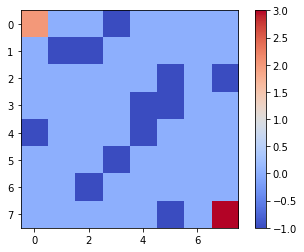

In [225]:
import matplotlib.pyplot as plt

def display_grid_test(grid, start, goal, obstacles, path):
    # Create a grid with obstacles
    grid_with_obstacles = grid.copy()
    for obstacle in obstacles:
        grid_with_obstacles[obstacle] = -1

    # Add start, goal, and path positions
    grid_with_obstacles[start] = 2
    grid_with_obstacles[goal] = 3
    for position in path:
        if position not in (start, goal):
            grid_with_obstacles[position] = 1

    # Display the grid
    plt.imshow(grid_with_obstacles, cmap="coolwarm")
    plt.colorbar()
    plt.show()

def test_dqn(dqn, grid, start, goal, obstacles, max_steps=50):
    state = create_local_state(grid, start)
    current_position = start
    steps = 0
    path = [start]

    while current_position != goal and steps < max_steps:
        # Choose the best action
        action = torch.argmax(dqn(state.unsqueeze(0).to(device))).item()

        # Perform the action and get the next state
        if action == 0:  # up
            next_position = (max(current_position[0] - 1, 0), current_position[1])
        elif action == 1:  # down
            next_position = (min(current_position[0] + 1, 7), current_position[1])
        elif action == 2:  # left
            next_position = (current_position[0], max(current_position[1] - 1, 0))
        elif action == 3:  # right
            next_position = (current_position[0], min(current_position[1] + 1, 7))

        # If collided with an obstacle, don't change the position
        if next_position in obstacles:
            next_position = current_position

        # Update the state and position
        state = create_local_state(grid, next_position)
        current_position = next_position
        path.append(current_position)

        steps += 1

    return path

# Test the trained DQN and get the path
path = test_dqn(dqn, grid, start, goal, obstacles)

# Display the grid with obstacles and the path
display_grid_test(grid, start, goal, obstacles, path)


In [202]:
# create_local_state(grid, start)

In [203]:
# action = 1

In [204]:
# np.unravel_index(np.argmax(state.cpu().numpy() == 2), grid.shape)

In [205]:
# # Perform the action and get the next state
# current_position = np.unravel_index(np.argmax(state.cpu().numpy() == 2), grid.shape)
# if action == 0:  # up
#     next_position = (max(current_position[0] - 1, 0), current_position[1])
# elif action == 1:  # down
#     next_position = (min(current_position[0] + 1, 7), current_position[1])
# elif action == 2:  # left
#     next_position = (current_position[0], max(current_position[1] - 1, 0))
# elif action == 3:  # right
#     next_position = (current_position[0], min(current_position[1] + 1, 7))

# next_state = create_local_state(grid, next_position)